In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("listings.csv", low_memory=False) 

In [3]:
data.shape

(20025, 106)

In [4]:
# consider only prices and neigh
data = data[['price', 'neighbourhood','latitude','longitude']]

In [5]:
#convert prices to float
def convert_to_float(value):
    # remove ","
    string = value[1:].replace(",","")
    return float(string)

data['price'] = data['price'].apply(lambda x: convert_to_float(x))

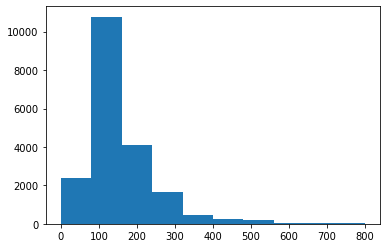

In [6]:
plt.hist(data['price'].values, range=(0, 800))
plt.show()

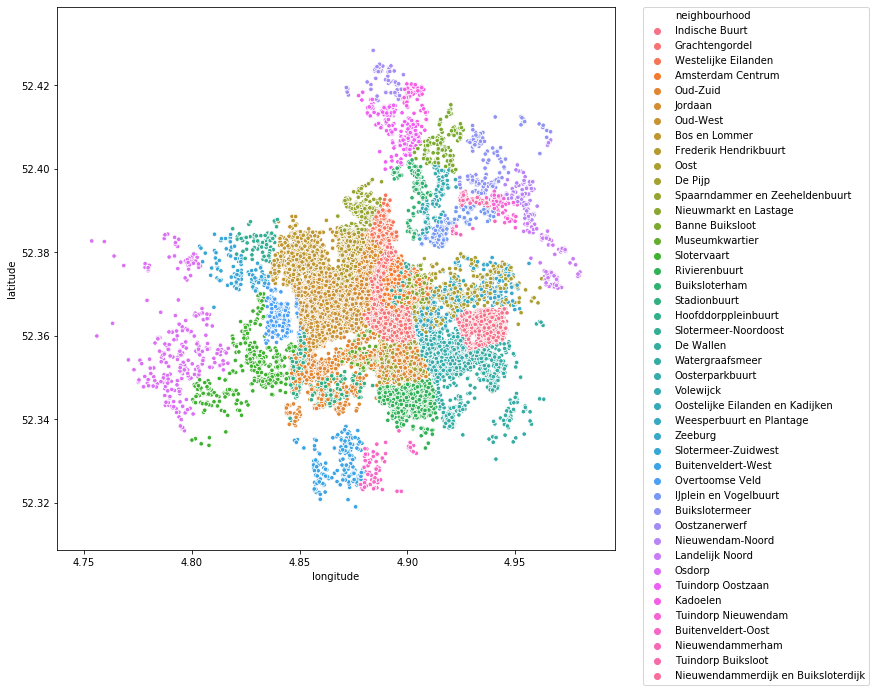

In [24]:
# plot neighbourhoods
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [25]:
#load geojson
geodf = gpd.read_file('neighbourhoods.geojson')

## Find correspondence between locations and geojson neigh

In [26]:
#Create a point of each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
datageom = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

#Now, do a spatial join... This code here runs an intersect analysis to find which neighborhood the Airbnb location is in
joined = gpd.sjoin(geodf, datageom, how='inner', op='intersects')
#N.B. some data are removed if not in any polygon

#Rename the column. 
joined.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

#Drop the second geometry column
joined.drop(columns='geometry', inplace=True)



/home/riccardo/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


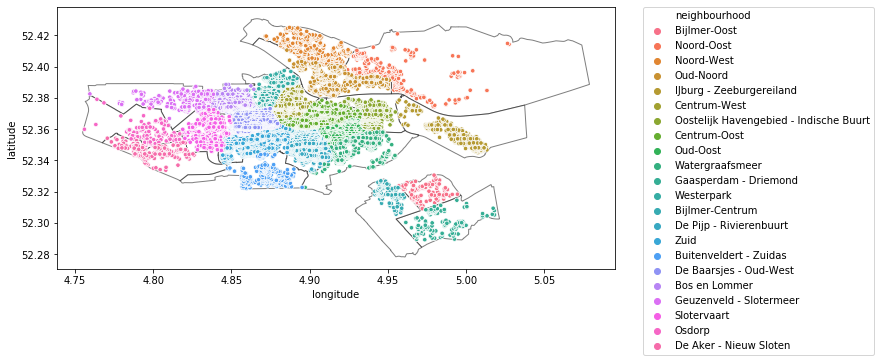

In [28]:
# plot neighbourhoods
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = geodf.plot(color='white',alpha=0.5, edgecolor='black', ax=ax1)
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=joined)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

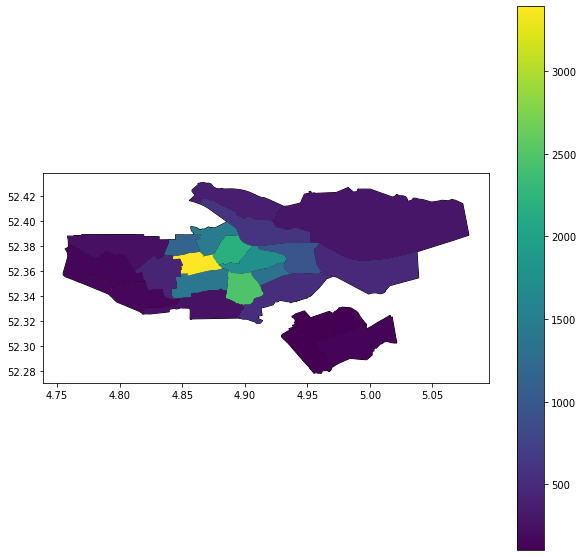

In [29]:
#Create a count of each neighborhood
nb_join_count = joined.groupby('neighbourhood').agg('count').reset_index()

#Get the "true count". Join this data to the original neighborhoods geometry 
true_count = geodf.merge(nb_join_count, on='neighbourhood')

#Lets plot number of observations in each area
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = geodf.plot(color='white', edgecolor='black', ax=ax)
true_count.plot(column='price',cmap='viridis', ax=base, legend=True)
#plt.title('Number of Airbnb listings by Neighborhood in Amsterdam')
plt.show()



In [30]:
data_clean = joined[['neighbourhood', 'price']]             

In [31]:
# convert data to list of lists
grouped = data_clean.groupby(['neighbourhood']).apply(lambda x: x['price'].values.tolist())
neigh = grouped.index.values

l = []
low = 1
up = 1000
for index, value in grouped.items():
    val = np.array(value)
    l.append(val[np.where(np.logical_and(val<up, val>low))[0]])

In [32]:
# remove empty neigh from geodf
drop_ind = [ i for i in range(geodf.shape[0]) if geodf['neighbourhood'].iloc[i] not in neigh]
geodf.drop(drop_ind, inplace=True, axis=0)
geodf = geodf.reset_index()

In [33]:
# build W
neigh_map = {k: i for i,k in enumerate(neigh) }

n = len(neigh)
W = np.zeros((n, n))
for index, value in geodf.iterrows():  
    # get 'not disjoint' countries
    neighbors = geodf[~geodf.geometry.disjoint(value.geometry)].neighbourhood.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if value.neighbourhood != name ]
    # get indices
    neighbors_indices = [i for i in range(n) if neigh[i] in neighbors]
    # W is 1 for neighbors
    W[neigh_map[value.neighbourhood], neighbors_indices] = 1   

In [34]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
#matprint(W)

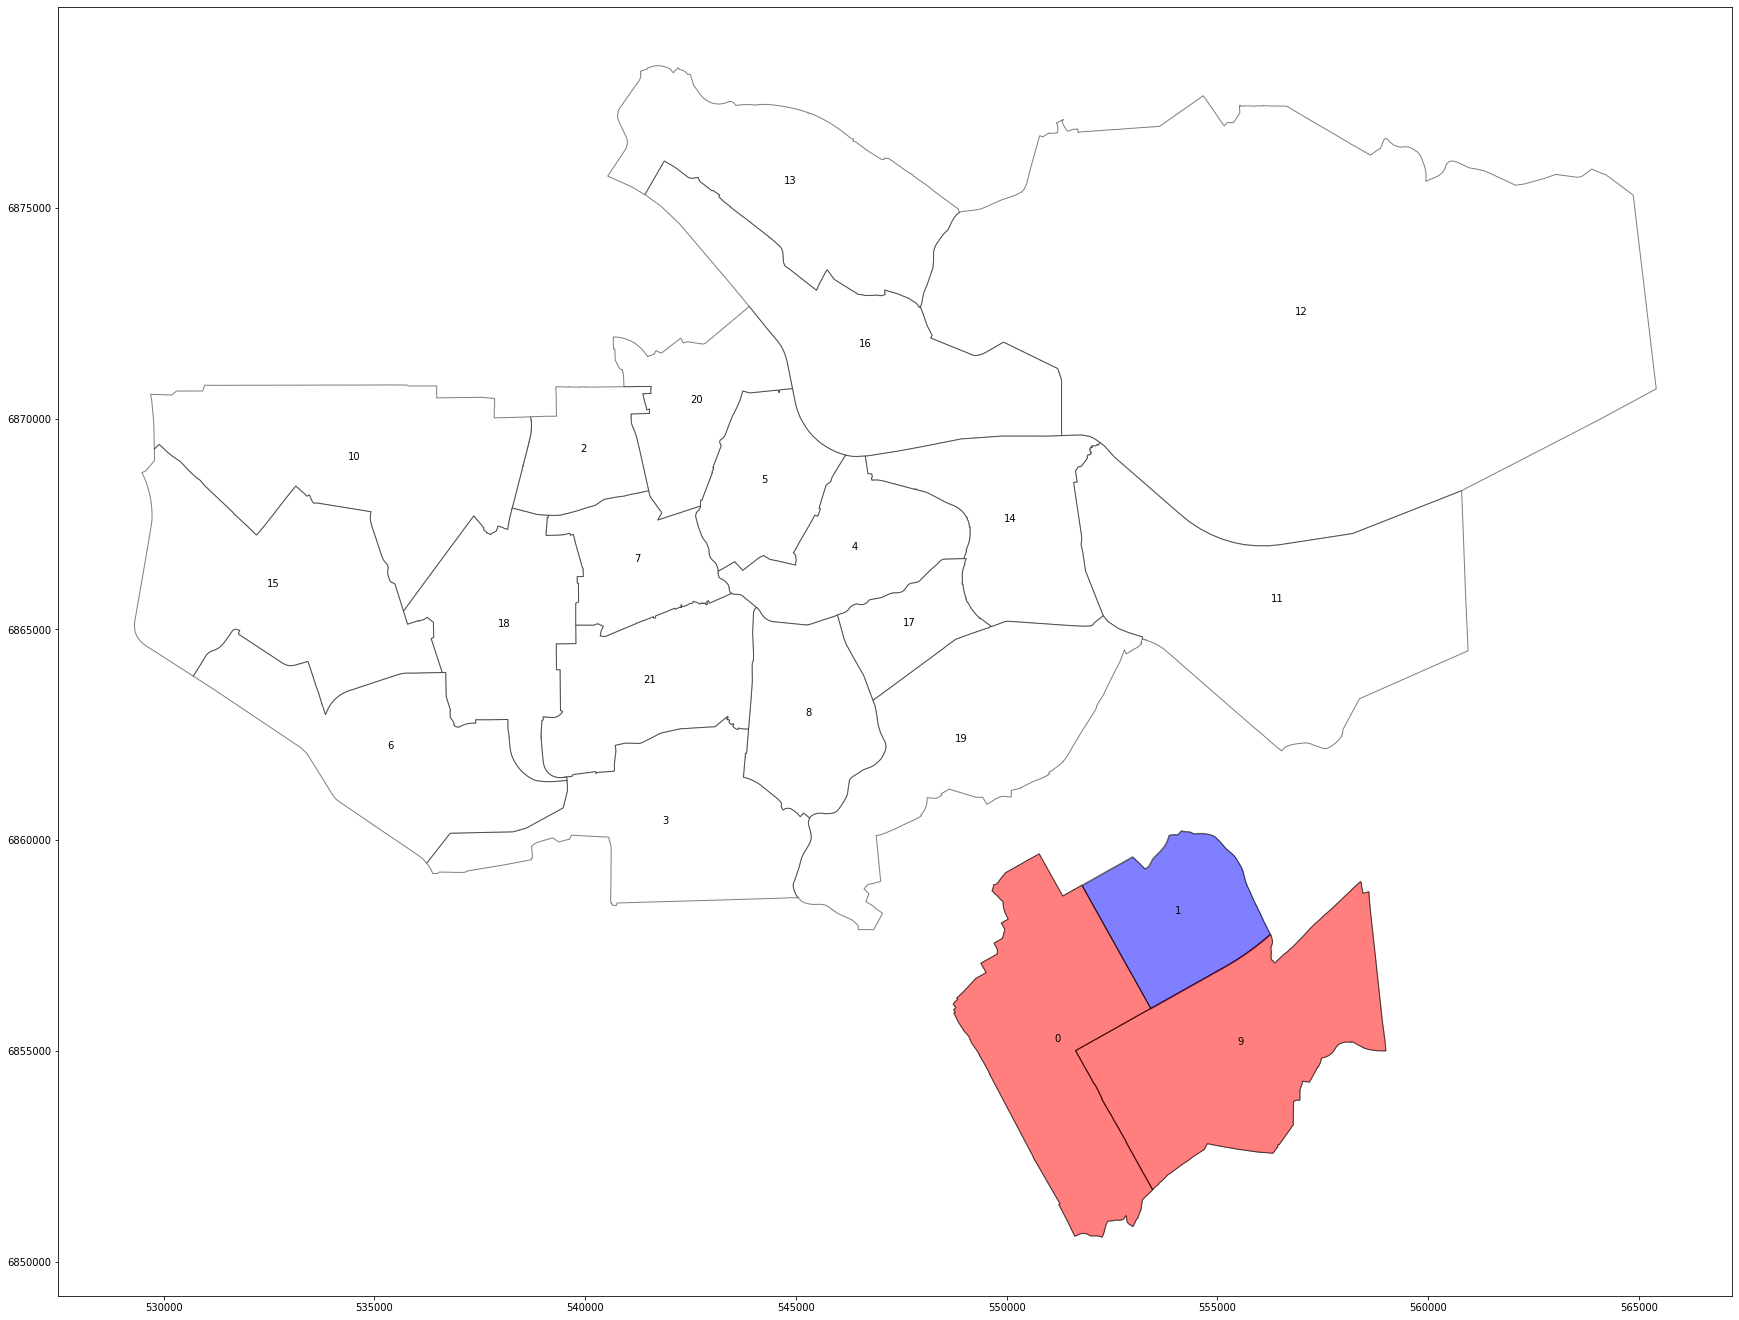

In [40]:
j=1
fig,ax1 = plt.subplots(1,1, figsize=(30,30))

ax2 = geodf.plot(color='white',alpha=0.5, edgecolor='black', ax=ax1)
ax3 = geodf.iloc[np.where(geodf['neighbourhood']==neigh[j])[0],:].plot(color='blue',
                                                                       alpha=0.5, edgecolor='black', ax=ax2)

geodf.iloc[np.where(geodf['neighbourhood'].isin(neigh[np.where(W[j,:])[0]]))[0],:].plot(
    color='red',alpha=0.5, edgecolor='black', ax=ax3)
geodf.apply(lambda x: ax3.annotate(s=neigh_map[x.neighbourhood], color='black', 
                                   xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.show()

In [35]:
# 1 e 15 non sono vicini
W[3,18] = 0
W[18,3] = 0

In [36]:
# save W and l
import pickle

d={'data':l, 'W':W, 'names':neigh}
with open('/home/riccardo/Desktop/spatial_lda/data/amsterdam.pkl', 'wb') as f:
    pickle.dump(d, f)
    

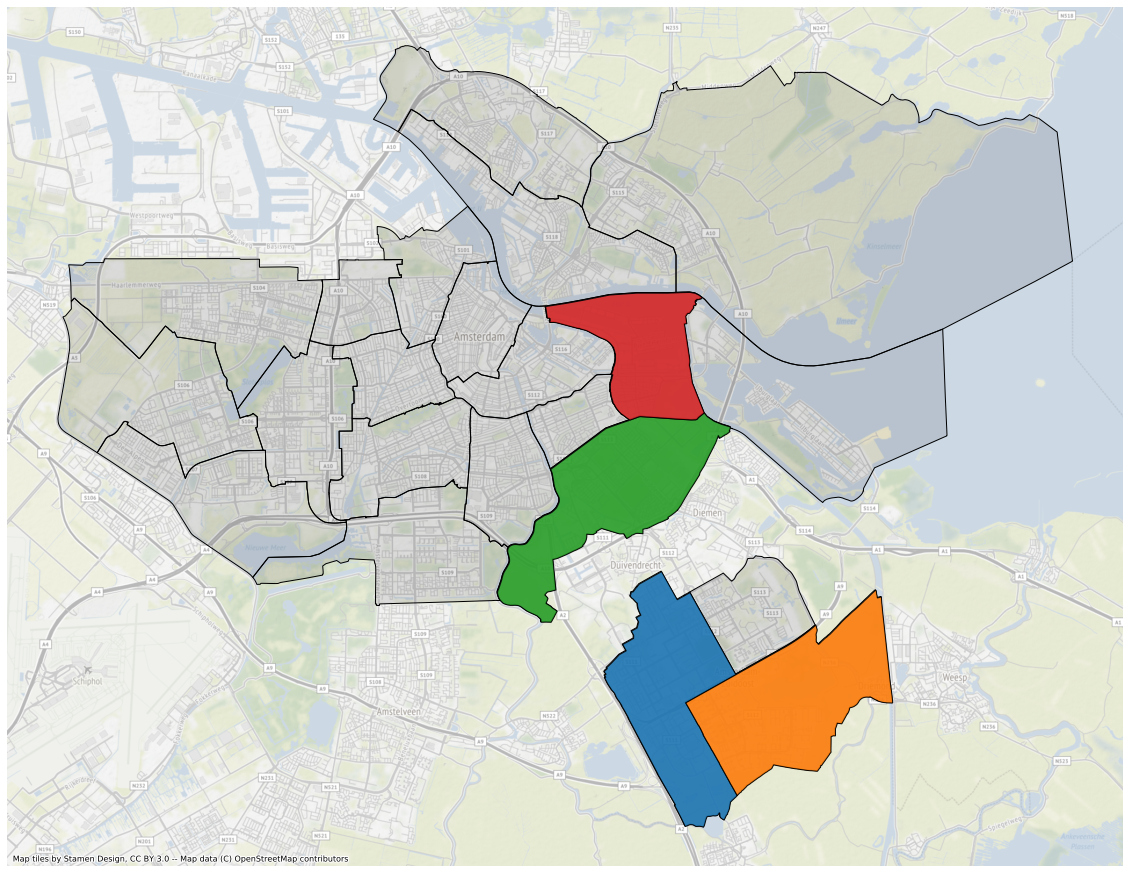

In [39]:
import contextily as ctx
# plot densità stimate
indices = [0, 9, 19, 14]
palette = sns.color_palette()

geodf = geodf.to_crs(epsg=3857)

fig,ax = plt.subplots(1,1, figsize=(20,20))

ax = geodf.plot(fc=(0,0,0,0.1), edgecolor='black', ax=ax)

for i in range(len(indices)):
    ax = geodf.iloc[np.where(geodf['neighbourhood']==neigh[indices[i]])[0],:].plot(color=palette[i],
                                                                       alpha=0.9, edgecolor='black', ax=ax)
ctx.add_basemap(ax, alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()
#ax.set_aspect('auto')

#geodf.apply(lambda x: ax.annotate(s=x.neighbourhood, color='black', 
#                                   xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
#plt.show()
plt.savefig('dens_estimates_neigh.pdf')